Dans cette section, nous faisons une briève analyse des sentiments sur la SNCF à partir des quelques tweets récupérés. Nous reproduisons principalement un [ancien projet](https://github.com/kidrissa/projetpy) de ce cours de python. Cette analyse est assez limitée en ce sens que nous ne sommes basés que sur moins de 300 tweets récupérés sur un très courte période (une démi-journée).

In [39]:
# Installation des modules nécessaires
#!pip install demoji
#!python -m spacy download fr_core_news_md
#!pip install textblob
#!pip install textblob-fr

In [54]:
#Importation des modules
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
import nltk
from nltk.corpus import stopwords
import re
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import TextBlob, Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

In [23]:
nlp = spacy.load('fr_core_news_md')

In [93]:
### Importation et préparation de la base de données
tweets=pd.read_csv("Jeux de données/tweets.csv", index_col=0)

Certains tweets peuvent avoir été postés à différentes heures par le même auteur ou peuvent être des retweets. Nous supprimons ces tweets.

In [94]:
tweets.drop_duplicates(subset = "Tweet", keep = 'first', inplace=True, ignore_index = True)
tweets.head(10)

,User,Tweet,timeTweet,source,retweet
0,Arki987,@pabliigoo @SNCF Celui de 14h50,2022-12-16 13:50:02+00:00,Twitter for iPhone,0
1,Im_Gi_,@Etohzz @SNCF @Elysee *,2022-12-16 13:49:50+00:00,Twitter for iPhone,0
2,Rayn_TN,@SNCF tgv inoui 2730 a destination de paris,2022-12-16 13:49:20+00:00,Twitter for iPhone,0
3,pabliigoo,@Arki987 @SNCF wesh comment ça,2022-12-16 13:48:30+00:00,Twitter for Android,0
4,dirtyswift,@ov_ostan @SNCF Mais bro… La ils me mettent en...,2022-12-16 13:47:53+00:00,Twitter for iPhone,0
5,Arki987,Train suivant supprimé 👌\r\n\r\nJe vous hais @...,2022-12-16 13:46:36+00:00,Twitter for iPhone,0
6,Rayn_TN,@SNCF le tgv bloquer à reims depuis 30min qui ...,2022-12-16 13:46:33+00:00,Twitter for iPhone,0
7,jabarre81,@SNCF @GroupeSNCF Bonjour merci je viens de vo...,2022-12-16 13:46:08+00:00,Twitter for Android,0
8,saint_dolly,Ce serait bien de mettre l'application à jour ...,2022-12-16 13:44:10+00:00,Twitter Web App,0
9,Rayn_TN,@SNCF c’est quand mon tgv il part svp il se pa...,2022-12-16 13:42:50+00:00,Twitter for iPhone,0


In [97]:
tweets.shape

(286, 5)

286 différents tweets ont été récupérés au cours de la journée du 16 décembre 2022 entre 07h à 13h.

## Nettoyage des tweets

On retire des tweets les caractères spéciaux, les émojis, les ponctuations, à tranformer les majuscules en minuscule,... grâce à la fonction `transforme`. Les tweets ainsi nettoyés sont contenus dans la variable `texte_propre`.

In [26]:
def transforme(texte):
    texte = texte.lower() # mettre les mots en minuscule
    #retirer les liens
    for item in re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+").findall(texte):
        texte=texte.replace(item, "")
    # enlever le retour à la ligne
    texte = texte.replace("\n", " ").replace("\r", "") 
    # supprimer ",", "!", "?", "%", "(",")","/",'"', "$","£", "_", "-", "+", "*", "µ", ":","&,"§" 
    texte = re.sub(r"[,\!\?\%\(\)\/\"\$\£\+\*\µ,\:\&\§]", " ", texte) 
    # retirer les hashtags #
    for item in re.compile("([#]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les apostrophes '
    for item in re.compile("([\’])").findall(texte):
        texte=texte.replace(item, " ")
    for item in re.compile("([\'])").findall(texte):
        texte=texte.replace(item, " ")
    # retirer les points de suspension
    for item in re.compile("([.]{1,5})").findall(texte):
        texte=texte.replace(item, "") 
    # retirer les personnes tagées
    for item in re.compile("([@]\w+)").findall(texte):
        texte=texte.replace(item, "")
    # retirer les adresses mail
    for item in re.findall('\S+@\S+', texte) :
        texte=texte.replace(item, "")
    # retire les mots contenant des chiffres
    texte = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", texte)
    # retirer les emojis
    for item in demoji.findall(texte):
        texte=texte.replace(item,"")
    return texte

In [27]:
tweets["texte_propre"] = tweets["Tweet"].apply(lambda x: transforme(x))
tweets.head()

,User,Tweet,timeTweet,source,retweet,texte_propre
0,Arki987,@pabliigoo @SNCF Celui de 14h50,2022-12-16 13:50:02+00:00,Twitter for iPhone,0,celui de
1,Im_Gi_,@Etohzz @SNCF @Elysee *,2022-12-16 13:49:50+00:00,Twitter for iPhone,0,
2,Rayn_TN,@SNCF tgv inoui 2730 a destination de paris,2022-12-16 13:49:20+00:00,Twitter for iPhone,0,tgv inoui a destination de paris
3,pabliigoo,@Arki987 @SNCF wesh comment ça,2022-12-16 13:48:30+00:00,Twitter for Android,0,wesh comment ça
4,dirtyswift,@ov_ostan @SNCF Mais bro… La ils me mettent en...,2022-12-16 13:47:53+00:00,Twitter for iPhone,0,mais bro… la ils me mettent en galère…


Nous procédons ensuite à la lemmatisation du texte qui consiste à remplaçer les différentes formes d’un même mot (pluriel, singulier, conjugaison) par une même forme dite canonique. Le résultat est stocké dans la variable `texte_lemmatise`

In [28]:
def decoupe_lemmatise(text):
    nlp_text = nlp(text)
    dict_lemm = {token : token.lemma_ for token in nlp_text}
    # list_mot = text.split()
    list_mots = []
    for x in nlp_text : 
        if len(x) >= 0 :
            list_mots.append(dict_lemm[x])
    return ' '.join(list_mots)

In [29]:
tweets["texte_lemmatise"] = tweets["texte_propre"].apply(decoupe_lemmatise)
tweets.head()

,User,Tweet,timeTweet,source,retweet,texte_propre,texte_lemmatise
0,Arki987,@pabliigoo @SNCF Celui de 14h50,2022-12-16 13:50:02+00:00,Twitter for iPhone,0,celui de,celui de
1,Im_Gi_,@Etohzz @SNCF @Elysee *,2022-12-16 13:49:50+00:00,Twitter for iPhone,0,,
2,Rayn_TN,@SNCF tgv inoui 2730 a destination de paris,2022-12-16 13:49:20+00:00,Twitter for iPhone,0,tgv inoui a destination de paris,tgv inoui avoir destination de pari
3,pabliigoo,@Arki987 @SNCF wesh comment ça,2022-12-16 13:48:30+00:00,Twitter for Android,0,wesh comment ça,wesh comment cela
4,dirtyswift,@ov_ostan @SNCF Mais bro… La ils me mettent en...,2022-12-16 13:47:53+00:00,Twitter for iPhone,0,mais bro… la ils me mettent en galère…,mais bro … le il me mettre en galère …


On peut désormais retirer les stop words qui n'apportent pas de sens.

In [81]:
#Liste des stopwords
stop_words = nlp.Defaults.stop_words
stop_words_contexte = ["train", "trains", "sncf", "ter", "après", "alors", "sans", "tgv", "réseau", "gare", "voie", "lors", "suite",
"conducteur", "voyageur", "voyageurs", "circulation", "agent", "agents","passager", "passagers", "entre", "plusieurs", "entre",
"circulations", "passage", "non", "avant", "voies", "circule", "plus", "bonjour", "faire", "aller", "prendre", "pouvoir", "jeu",
"jour", "euro", "voir", "bien"]
stop_words = list(stop_words) + stop_words_contexte
# stop_words 

In [82]:
# retirer les stopwords
def retrait_sw(text):
    return [w for w in text.split() if w not in stop_words]

tweets["liste_mots"] = tweets["texte_lemmatise"].apply(retrait_sw)
tweets.head()

,User,Tweet,timeTweet,source,retweet,texte_propre,texte_lemmatise,liste_mots,score_polarite,label_car,label
0,Arki987,@pabliigoo @SNCF Celui de 14h50,2022-12-16 13:50:02+00:00,Twitter for iPhone,0,celui de,celui de,[],0.0,neutre,0
1,Im_Gi_,@Etohzz @SNCF @Elysee *,2022-12-16 13:49:50+00:00,Twitter for iPhone,0,,,[],0.0,neutre,0
2,Rayn_TN,@SNCF tgv inoui 2730 a destination de paris,2022-12-16 13:49:20+00:00,Twitter for iPhone,0,tgv inoui a destination de paris,tgv inoui avoir destination de pari,"[inoui, destination, pari]",0.0,neutre,0
3,pabliigoo,@Arki987 @SNCF wesh comment ça,2022-12-16 13:48:30+00:00,Twitter for Android,0,wesh comment ça,wesh comment cela,[wesh],0.0,neutre,0
4,dirtyswift,@ov_ostan @SNCF Mais bro… La ils me mettent en...,2022-12-16 13:47:53+00:00,Twitter for iPhone,0,mais bro… la ils me mettent en galère…,mais bro … le il me mettre en galère …,"[bro, …, mettre, galère, …]",0.0,neutre,0


## Calcul du sentiment à partir de la polarité de Textblob

Ceci est fait grâce au package textblob qui renvoie deux valeurs dont la polarité qui est positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif. La seconde valeur représente la subjectivité de l'analyse. Plus elle est proche de 0 et plus l'analyse est objective.

In [83]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [84]:
def tweet_polarite(text):
    return tb(text).sentiment[0]

Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet. Deux variables sont crées.

In [85]:
def tweet_label_car(text):
    if tweet_polarite(text) > 0 :
        return "positif"
    if tweet_polarite(text) < 0 :
        return "negatif"
    return "neutre"

def tweet_label(text):
    if tweet_polarite(text) > 0 :
        return 1
    if tweet_polarite(text) < 0 :
        return -1
    return 0

In [86]:
tweets["score_polarite"] = tweets["texte_lemmatise"].apply(tweet_polarite)

tweets["label_car"] = tweets["texte_lemmatise"].apply(tweet_label_car)

tweets["label"] = tweets["texte_lemmatise"].apply(tweet_label)

Comme le montre la sortie ci-dessous, au niveau de la variable "label", on a les modalités -1, 0 et 1 et la variable "label_car" donne la définition de cette codification.

In [87]:
tweets

,User,Tweet,timeTweet,source,retweet,texte_propre,texte_lemmatise,liste_mots,score_polarite,label_car,label
0,Arki987,@pabliigoo @SNCF Celui de 14h50,2022-12-16 13:50:02+00:00,Twitter for iPhone,0,celui de,celui de,[],0.0000,neutre,0
1,Im_Gi_,@Etohzz @SNCF @Elysee *,2022-12-16 13:49:50+00:00,Twitter for iPhone,0,,,[],0.0000,neutre,0
2,Rayn_TN,@SNCF tgv inoui 2730 a destination de paris,2022-12-16 13:49:20+00:00,Twitter for iPhone,0,tgv inoui a destination de paris,tgv inoui avoir destination de pari,"[inoui, destination, pari]",0.0000,neutre,0
3,pabliigoo,@Arki987 @SNCF wesh comment ça,2022-12-16 13:48:30+00:00,Twitter for Android,0,wesh comment ça,wesh comment cela,[wesh],0.0000,neutre,0
4,dirtyswift,@ov_ostan @SNCF Mais bro… La ils me mettent en...,2022-12-16 13:47:53+00:00,Twitter for iPhone,0,mais bro… la ils me mettent en galère…,mais bro … le il me mettre en galère …,"[bro, …, mettre, galère, …]",0.0000,neutre,0
...,...,...,...,...,...,...,...,...,...,...,...
281,LeJurassien_,@AMimardo @PK674_129 @bfc_region @Conducteurdu...,2022-12-16 07:04:31+00:00,Twitter for Android,0,le pire c est qu on voit bien que peu im...,le pire c être qu on voir bien que peu ...,"[pire, c, qu, couleur, politique, incompétent,...",-0.0880,negatif,-1
282,JulienTaillez,@tonytudors @UNSAFerro_Off @chivotjl @SNCF Vou...,2022-12-16 07:04:15+00:00,Twitter for iPhone,0,vous me faites marrer tellement des miett...,vous me faire marrer tellement de miett...,"[marrer, miette, tract, unser, destination, as...",0.1400,positif,1
283,Aurasama_a,A ce niveau c’est du foutage de gueule 45 min ...,2022-12-16 07:03:41+00:00,Twitter for iPhone,0,a ce niveau c est du foutage de gueule min de...,avoir ce niveau c être de foutage de gueule ...,"[niveau, c, foutage, gueule, min, retard, mtn,...",-0.3275,negatif,-1
284,CarolineRanson3,@GroupeSNCF pour une fois qu’un @TERHDF est à ...,2022-12-16 07:03:14+00:00,Twitter for iPhone,0,pour une fois qu un est à l heure vous arriv...,pour un fois qu un être à l heure vous arr...,"[fois, qu, l, heure, arriver, contrôler, mettr...",-0.1000,negatif,-1


## Répartition des tweets selon le sentiment
On procède à une répartition des tweets selon les sentiments définis par `TextBlob.`

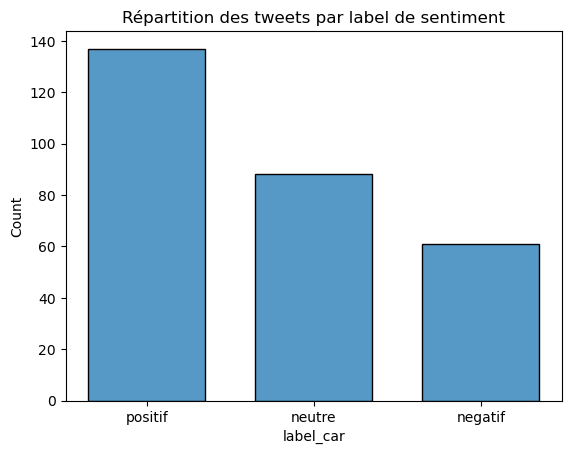

In [88]:
sns.histplot(tweets.sort_values("label_car", ascending=False), x="label_car",  shrink=0.7)# , palette=customPalette)
plt.title("Répartition des tweets par label de sentiment")
plt.show()

Près de la moitié des tweets ont été désignés par TextBlob comme positifs en terme de sentiment, l'autre moitié étant constituée de plus de tweets neutres. Ce résultat ne réflète pas la réalité de l'information contenue dans les tweets. Cela pourrait être dû au faible nombre de tweets récupérés.

## Visualisation avec WordCloud selon le sentiment
On se propose ici de visualiser les wordclouds selon le sentiment.  Il ressort les mots redondants qui peuvent attirer l'attention sur un ou plusieurs aspects importants qui justifiraient le sentiment contenu dans les commentaires.

In [89]:
import random

def couleur_rouge(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def couleur_verte(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def couleur_jaune(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [90]:
def trace_3_wordclouds_alignes(mots_neg, mots_neu, mots_pos):
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    
    wordcloud_neg = WordCloud(stopwords=stop_words,
                          background_color='white', # mask=mask_bavette,# width=mask.shape[1], height=mask.shape[0],
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Reds'
                         ).generate(mots_neg)
    axes[0].imshow(wordcloud_neg.recolor(color_func=couleur_rouge, random_state=3), interpolation='bilinear')
    axes[0].set_title("Sentiment négatif", size=20)
    axes[0].axis("off")

    wordcloud_neu = WordCloud(stopwords=stop_words,
                          background_color='white',
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_neu)
    axes[1].imshow(wordcloud_neu.recolor(color_func=couleur_jaune, random_state=3), interpolation='bilinear')
    axes[1].set_title("Sentiment neutre", size=20)
    axes[1].axis("off")

    wordcloud_pos = WordCloud(stopwords=stop_words,
                          background_color='white', #mask=mask_vaccin, 
                          collocations=False, collocation_threshold=100,
                          max_words=100, min_word_length=4, colormap='Greens'
                         ).generate(mots_pos)
    axes[2].imshow(wordcloud_pos.recolor(color_func=couleur_verte, random_state=3), interpolation='bilinear')
    axes[2].set_title("Sentiment positif", size=20)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

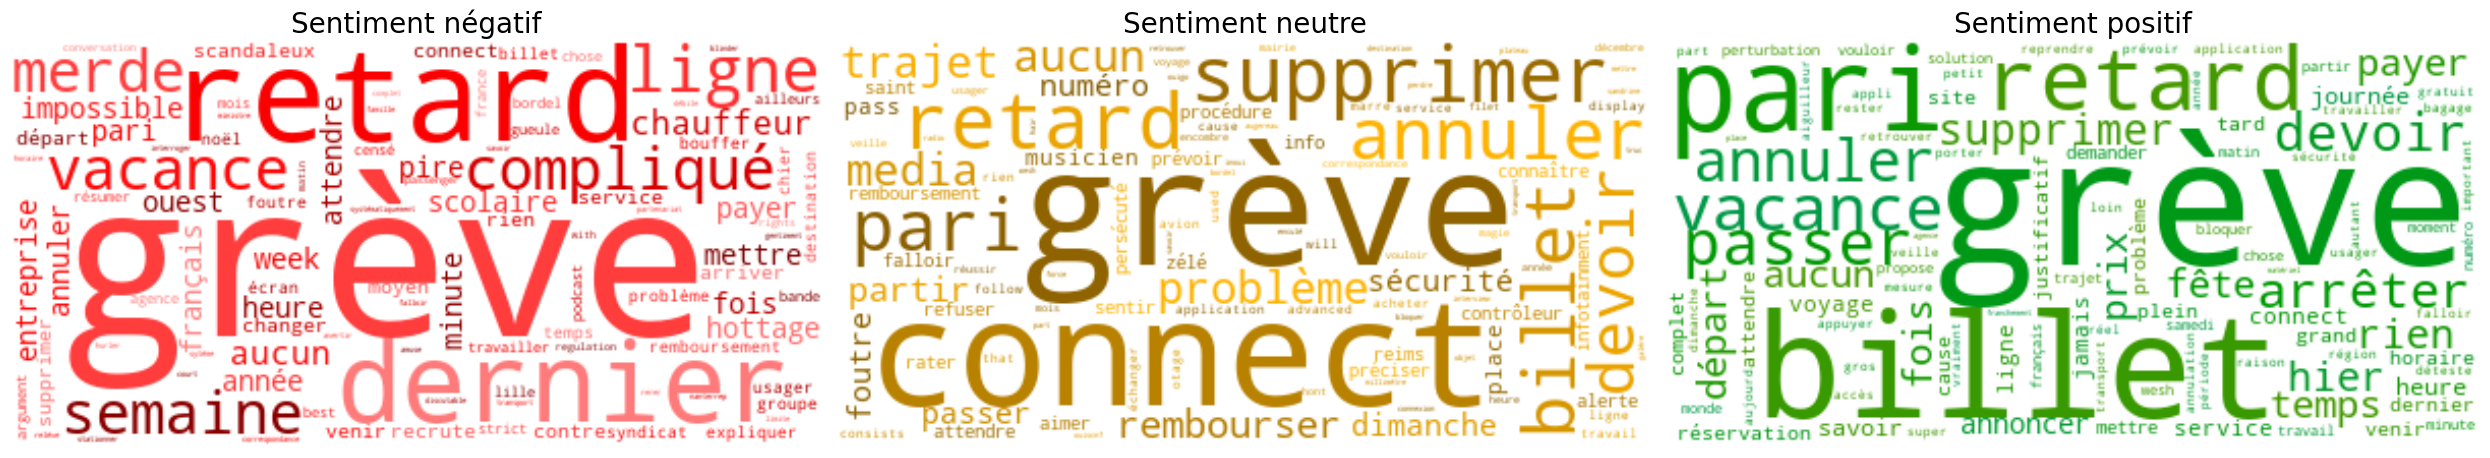

In [91]:
df_pos = tweets[tweets['label']==1]
mots_pos = ' '.join(df_pos['texte_lemmatise'])

df_neg = tweets[tweets['label']==-1]
mots_neg = ' '.join(df_neg['texte_lemmatise'])

df_neu = tweets[tweets['label']==0]
mots_neu = ' '.join(df_neu['texte_lemmatise'])

trace_3_wordclouds_alignes(mots_neg, mots_neu, mots_pos)


Les commentaires à connotation négative sur la SNCF ont mis l'accent sur le retard, les grèves, le remboursement, l'annulation...